In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import plotly.graph_objects as go

In [8]:
path_corpus_tut = Path('../data/corpora/tutby_126784.csv')
path_ner_data = Path('../data/ner/ner_tutby_126784.json')

path_plot_per = Path('../data/plot/ner_per_tutby_126784.html')
path_plot_loc = Path('../data/plot/ner_loc_tutby_126784.html')
path_plot_org = Path('../data/plot/ner_org_tutby_126784.html')

In [3]:
%%time

entities = pd.read_json(path_ner_data, orient='records', encoding='cp1251', lines=True)

data = pd.read_csv(path_corpus_tut)
data['ner'] = entities['ner']

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

print(data.shape)
display(data.head())

(126784, 7)


,url,label,header,date,document,tags,ner
122955,https://news.tut.by/695801.html,Обзоры,Где заняться вейкбордингом в Беларуси,2015-08-27 15:54:00+03:00,"\nЛето заканчивается, а с ним и забавы на воде...","['досуг, хобби', 'спорт', 'дороги']","[[tut.by, ORG], [Вейкбординг, PER], [Вейкборди..."
126602,https://news.tut.by/700088.html,Обзоры,Где заняться вейкбордингом в Беларуси,2015-08-27 15:54:00+03:00,"\nЛето заканчивается, а с ним и забавы на воде...","['досуг, хобби', 'спорт', 'дороги']","[[tut.by, ORG], [Вейкбординг, PER], [Вейкборди..."
0,https://news.tut.by/550306.html,Футбол,"Тренер ""Шахтера"": Оправдываться не хочу. Все в...",2017-07-06 21:35:00+03:00,Главный тренер солигорского «Шахтера» Олег Куб...,['футбол'],"[[шахтер, ORG], [олег кубарев, PER], [литва, L..."
3,https://news.tut.by/550309.html,Футбол,Станислав Драгун дебютировал за БАТЭ в матче с...,2017-07-06 22:11:00+03:00,Чемпион Беларуси БАТЭ воспользовался паузой в ...,"['футбол', 'БАТЭ']","[[батэ, ORG], [борис-арена, ORG], [жальгирис, ..."
4,https://news.tut.by/550310.html,В мире,Генпрокурор Украины пообещал открыть уголовное...,2017-07-06 22:28:00+03:00,Генпрокуратура Украины откроет уголовное произ...,"['Ситуация в Украине', 'государственные перево...","[[генпрокуратура, ORG], [украина, LOC], [викто..."


Wall time: 14 s


In [4]:
entities = data[['date', 'ner']]

entities = entities.explode('ner')
entities = entities[entities['ner'].notna()]

entities['ner_tag'] = entities['ner'].map(lambda _: _[1])
entities['ner'] = entities['ner'].map(lambda _: _[0])

entities_per = entities[entities['ner_tag'] == 'PER']
entities_loc = entities[entities['ner_tag'] == 'LOC']
entities_org = entities[entities['ner_tag'] == 'ORG']

display(entities_per.head())
display(entities_loc.head())
display(entities_org.head())

,date,ner,ner_tag
122955,2015-08-27 15:54:00+03:00,Вейкбординг,PER
122955,2015-08-27 15:54:00+03:00,Вейкбордист,PER
122955,2015-08-27 15:54:00+03:00,надежда дуко,PER
122955,2015-08-27 15:54:00+03:00,надежда,PER
122955,2015-08-27 15:54:00+03:00,райдер,PER


,date,ner,ner_tag
122955,2015-08-27 15:54:00+03:00,волковичское водохранилище,LOC
122955,2015-08-27 15:54:00+03:00,дрозд,LOC
122955,2015-08-27 15:54:00+03:00,беларусь,LOC
122955,2015-08-27 15:54:00+03:00,минск,LOC
122955,2015-08-27 15:54:00+03:00,кольцов,LOC


,date,ner,ner_tag
122955,2015-08-27 15:54:00+03:00,tut.by,ORG
122955,2015-08-27 15:54:00+03:00,dominant boardshop,ORG
122955,2015-08-27 15:54:00+03:00,wake line,ORG
122955,2015-08-27 15:54:00+03:00,afisha.tut.by. wakepark.by,ORG
122955,2015-08-27 15:54:00+03:00,гсок «логойск»,ORG


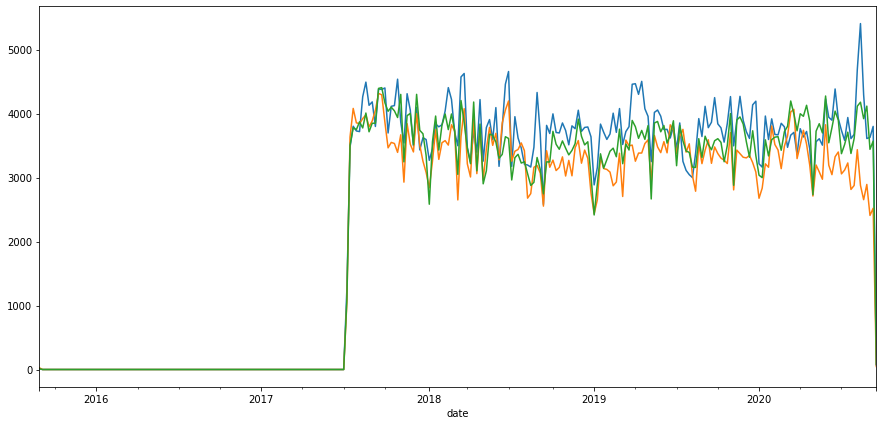

In [5]:
entities_per.resample('W', on='date')['date'].count().plot(figsize=(15,7));
entities_loc.resample('W', on='date')['date'].count().plot(figsize=(15,7));
entities_org.resample('W', on='date')['date'].count().plot(figsize=(15,7));

In [20]:
%%time

figure = go.Figure()

entities_ = entities_per

entities_count = entities_.resample('W', on='date')['date'].count()

top_entities = entities_['ner'].value_counts()[:500].index

for entity in tqdm(top_entities):
    ts_entity = entities_[entities_['ner'] == entity].resample('W', on='date')['date'].count()
    ts_entire = entities_count[ts_entity.index]
    ts = ts_entity / ts_entire
    ts = ts[ts_entire > 2000]
    if (ts.max() > 0.007):  # 0.007 0.015 0.010
        figure.add_scatter(x=ts.index, y=ts, mode='lines', name=entity)

figure.write_html(str(path_plot_per))


Wall time: 44.2 s
